In [1]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error,r2_score

e:\Machine Learning and Data Science\SHAP-Projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### DataSet

In [2]:
set_config(transform_output = "pandas")

In [3]:
# load the dataset
data = fetch_california_housing(as_frame=True)

In [4]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [5]:
X,y = data.data, data.target

In [6]:
features_names = data.feature_names

features_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [7]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [9]:
X.shape

(20640, 8)

In [10]:
# split the dataset

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("Training set shape:",X_train.shape)
print("Testing set shape:",X_test.shape)

Training set shape: (16512, 8)
Testing set shape: (4128, 8)


In [11]:
# model
xgb_model = XGBRegressor(objective='reg:squarederror',random_state=42,n_jobs=-1,learning_rate=0.2,n_estimators=200,reg_lambda=50,       max_depth=7)

In [12]:
# fit the training data
xgb_model.fit(X_train,y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [13]:
# calculate the predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

#calculate the evaluation metrics
rmse_train = root_mean_squared_error(y_train,y_pred_train)
rmse_test = root_mean_squared_error(y_test,y_pred_test)

r2_train = r2_score(y_train,y_pred_train)
r2_test = r2_score(y_test,y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2740, R2: 0.9438
Test RMSE: 0.4460, R2: 0.8482


### HP Tuning

In [14]:
# tune the model

def objective(trial):

    params = {
        "learning_rate":trial.suggest_float('learning_rate',0.01,0.3),
        'n_estimators': trial.suggest_int('n_estimators',50,500),
        'max_depth': trial.suggest_int('max_depth',3,10),
        'reg_lambda': trial.suggest_float('reg_lambda',1,100),
        'subsample': trial.suggest_float('subsample',0.7,1.0),
        'n_jobs':-1,
        'objective': 'reg:squarederror',
        'random_state':42
    }

    # set the model
    model = XGBRegressor()

    model.set_params(**params)

    #fit the model
    model.fit(X_train,y_train)

    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    
    return r2

In [15]:
# create the study
study = optuna.create_study(direction='maximize')

study.optimize(func=objective,n_trials=50,show_progress_bar=True,n_jobs=-1)

[I 2026-01-28 18:33:52,288] A new study created in memory with name: no-name-5d4eeafd-7831-4645-ad5b-3a2af04e767f
  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 2. Best value: 0.81484:   2%|▏         | 1/50 [00:02<01:50,  2.25s/it]

[I 2026-01-28 18:33:54,519] Trial 2 finished with value: 0.8148397987506828 and parameters: {'learning_rate': 0.2643482305388419, 'n_estimators': 129, 'max_depth': 3, 'reg_lambda': 67.77081510999359, 'subsample': 0.8368306102328985}. Best is trial 2 with value: 0.8148397987506828.


Best trial: 5. Best value: 0.834811:   4%|▍         | 2/50 [00:02<00:54,  1.13s/it]

[I 2026-01-28 18:33:54,879] Trial 5 finished with value: 0.8348108231947619 and parameters: {'learning_rate': 0.24327234501962544, 'n_estimators': 61, 'max_depth': 8, 'reg_lambda': 4.8051890068922996, 'subsample': 0.8581086793212563}. Best is trial 5 with value: 0.8348108231947619.
[I 2026-01-28 18:33:54,933] Trial 7 finished with value: 0.8250469584943786 and parameters: {'learning_rate': 0.27356206748244793, 'n_estimators': 123, 'max_depth': 4, 'reg_lambda': 73.21642742026204, 'subsample': 0.8792573153888511}. Best is trial 5 with value: 0.8348108231947619.


Best trial: 1. Best value: 0.836126:   8%|▊         | 4/50 [00:03<00:30,  1.50it/s]

[I 2026-01-28 18:33:55,664] Trial 1 finished with value: 0.8361255900109987 and parameters: {'learning_rate': 0.20117801030403346, 'n_estimators': 130, 'max_depth': 5, 'reg_lambda': 18.36677943496358, 'subsample': 0.9260729686126685}. Best is trial 1 with value: 0.8361255900109987.


[I 2026-01-28 18:33:57,258] Trial 0 finished with value: 0.8331373415866785 and parameters: {'learning_rate': 0.24823315932592055, 'n_estimators': 335, 'max_depth': 3, 'reg_lambda': 73.98772058305386, 'subsample': 0.8004813665693378}. Best is trial 1 with value: 0.8361255900109987.


Best trial: 1. Best value: 0.836126:  12%|█▏        | 6/50 [00:05<00:31,  1.40it/s]

[I 2026-01-28 18:33:57,432] Trial 3 finished with value: 0.8134337921777662 and parameters: {'learning_rate': 0.04388728003619091, 'n_estimators': 157, 'max_depth': 7, 'reg_lambda': 97.02412059452338, 'subsample': 0.9492273720792157}. Best is trial 1 with value: 0.8361255900109987.


Best trial: 4. Best value: 0.847429:  14%|█▍        | 7/50 [00:06<00:38,  1.13it/s]

[I 2026-01-28 18:33:58,713] Trial 4 finished with value: 0.8474287149994909 and parameters: {'learning_rate': 0.22373764277180974, 'n_estimators': 154, 'max_depth': 9, 'reg_lambda': 49.298003871526, 'subsample': 0.7953067032482283}. Best is trial 4 with value: 0.8474287149994909.


Best trial: 4. Best value: 0.847429:  16%|█▌        | 8/50 [00:08<00:56,  1.34s/it]

[I 2026-01-28 18:34:01,101] Trial 10 finished with value: 0.8399103461997812 and parameters: {'learning_rate': 0.05762967713132427, 'n_estimators': 188, 'max_depth': 8, 'reg_lambda': 27.147706085964863, 'subsample': 0.8026060044622594}. Best is trial 4 with value: 0.8474287149994909.


Best trial: 4. Best value: 0.847429:  18%|█▊        | 9/50 [00:11<01:05,  1.61s/it]

[I 2026-01-28 18:34:03,316] Trial 13 finished with value: 0.8250668520647857 and parameters: {'learning_rate': 0.10838164742010128, 'n_estimators': 500, 'max_depth': 3, 'reg_lambda': 56.31335493439371, 'subsample': 0.7397356489528546}. Best is trial 4 with value: 0.8474287149994909.
[I 2026-01-28 18:34:03,393] Trial 15 finished with value: 0.8125442616267979 and parameters: {'learning_rate': 0.11254811383969322, 'n_estimators': 159, 'max_depth': 4, 'reg_lambda': 98.14437735932003, 'subsample': 0.7923916181183298}. Best is trial 4 with value: 0.8474287149994909.


Best trial: 9. Best value: 0.848112:  22%|██▏       | 11/50 [00:11<00:37,  1.04it/s]

[I 2026-01-28 18:34:03,738] Trial 9 finished with value: 0.8481120375726472 and parameters: {'learning_rate': 0.1579123345147484, 'n_estimators': 279, 'max_depth': 8, 'reg_lambda': 29.49297660699368, 'subsample': 0.7421032842677386}. Best is trial 9 with value: 0.8481120375726472.


Best trial: 9. Best value: 0.848112:  24%|██▍       | 12/50 [00:11<00:32,  1.17it/s]

[I 2026-01-28 18:34:04,274] Trial 6 finished with value: 0.8478093706415549 and parameters: {'learning_rate': 0.2597419833357724, 'n_estimators': 497, 'max_depth': 6, 'reg_lambda': 81.78049125519529, 'subsample': 0.8725209486605526}. Best is trial 9 with value: 0.8481120375726472.


Best trial: 14. Best value: 0.849841:  26%|██▌       | 13/50 [00:12<00:26,  1.41it/s]

[I 2026-01-28 18:34:04,578] Trial 14 finished with value: 0.8498409723299019 and parameters: {'learning_rate': 0.27327307565137465, 'n_estimators': 383, 'max_depth': 4, 'reg_lambda': 55.71845084792018, 'subsample': 0.9540046417278911}. Best is trial 14 with value: 0.8498409723299019.
[I 2026-01-28 18:34:04,765] Trial 11 finished with value: 0.8492244948972913 and parameters: {'learning_rate': 0.08920976897449309, 'n_estimators': 398, 'max_depth': 6, 'reg_lambda': 48.89704146223318, 'subsample': 0.9842549788079697}. Best is trial 14 with value: 0.8498409723299019.


Best trial: 14. Best value: 0.849841:  30%|███       | 15/50 [00:14<00:37,  1.07s/it]

[I 2026-01-28 18:34:07,115] Trial 12 finished with value: 0.8482989116569709 and parameters: {'learning_rate': 0.2636826963422195, 'n_estimators': 335, 'max_depth': 7, 'reg_lambda': 88.44825848466654, 'subsample': 0.7926078990995393}. Best is trial 14 with value: 0.8498409723299019.


Best trial: 14. Best value: 0.849841:  32%|███▏      | 16/50 [00:20<01:19,  2.34s/it]

[I 2026-01-28 18:34:12,635] Trial 16 finished with value: 0.8442454415891368 and parameters: {'learning_rate': 0.0735183784871725, 'n_estimators': 176, 'max_depth': 10, 'reg_lambda': 21.475708601297, 'subsample': 0.8643471260047549}. Best is trial 14 with value: 0.8498409723299019.


Best trial: 14. Best value: 0.849841:  34%|███▍      | 17/50 [00:21<01:03,  1.93s/it]

[I 2026-01-28 18:34:13,564] Trial 8 finished with value: 0.8344362408210941 and parameters: {'learning_rate': 0.18288050474076717, 'n_estimators': 397, 'max_depth': 10, 'reg_lambda': 2.2555383394109816, 'subsample': 0.7919167729898208}. Best is trial 14 with value: 0.8498409723299019.


Best trial: 21. Best value: 0.854539:  38%|███▊      | 19/50 [00:23<00:45,  1.47s/it]

[I 2026-01-28 18:34:15,827] Trial 22 finished with value: 0.8505755664831559 and parameters: {'learning_rate': 0.16474112700515842, 'n_estimators': 410, 'max_depth': 5, 'reg_lambda': 47.10937874100754, 'subsample': 0.9997798776161473}. Best is trial 22 with value: 0.8505755664831559.
[I 2026-01-28 18:34:15,948] Trial 21 finished with value: 0.854538811438996 and parameters: {'learning_rate': 0.1627572079679404, 'n_estimators': 415, 'max_depth': 6, 'reg_lambda': 40.85248118192357, 'subsample': 0.9783919231999655}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  40%|████      | 20/50 [00:25<00:48,  1.62s/it]

[I 2026-01-28 18:34:17,932] Trial 18 finished with value: 0.8460564765569871 and parameters: {'learning_rate': 0.1780483170121239, 'n_estimators': 286, 'max_depth': 10, 'reg_lambda': 39.29724938158217, 'subsample': 0.7055338853084672}. Best is trial 21 with value: 0.854538811438996.
[I 2026-01-28 18:34:17,992] Trial 17 finished with value: 0.844025731681918 and parameters: {'learning_rate': 0.1829071455965806, 'n_estimators': 288, 'max_depth': 10, 'reg_lambda': 38.2692243158125, 'subsample': 0.7041363621266036}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  46%|████▌     | 23/50 [00:28<00:29,  1.10s/it]

[I 2026-01-28 18:34:20,266] Trial 20 finished with value: 0.8460836966055144 and parameters: {'learning_rate': 0.17939233819300504, 'n_estimators': 341, 'max_depth': 10, 'reg_lambda': 39.27246592106271, 'subsample': 0.9775550278864921}. Best is trial 21 with value: 0.854538811438996.
[I 2026-01-28 18:34:20,402] Trial 23 finished with value: 0.8529681078213389 and parameters: {'learning_rate': 0.17616535497403657, 'n_estimators': 434, 'max_depth': 5, 'reg_lambda': 46.21675077668938, 'subsample': 0.9900934318448102}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  48%|████▊     | 24/50 [00:28<00:24,  1.05it/s]

[I 2026-01-28 18:34:20,932] Trial 24 finished with value: 0.7943090123245687 and parameters: {'learning_rate': 0.014794615248428844, 'n_estimators': 427, 'max_depth': 5, 'reg_lambda': 46.00393659660555, 'subsample': 0.9981317258894312}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  52%|█████▏    | 26/50 [00:30<00:19,  1.24it/s]

[I 2026-01-28 18:34:22,289] Trial 19 finished with value: 0.843698804730087 and parameters: {'learning_rate': 0.1717207451204861, 'n_estimators': 402, 'max_depth': 10, 'reg_lambda': 35.377934537185986, 'subsample': 0.7044308803487603}. Best is trial 21 with value: 0.854538811438996.
[I 2026-01-28 18:34:22,440] Trial 25 finished with value: 0.7789766863188637 and parameters: {'learning_rate': 0.01099595437468448, 'n_estimators': 414, 'max_depth': 5, 'reg_lambda': 41.0213196784362, 'subsample': 0.9994010165642581}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  54%|█████▍    | 27/50 [00:30<00:16,  1.40it/s]

[I 2026-01-28 18:34:22,922] Trial 26 finished with value: 0.851888235131943 and parameters: {'learning_rate': 0.1520990215338728, 'n_estimators': 464, 'max_depth': 5, 'reg_lambda': 38.59427464546036, 'subsample': 0.9955897249301845}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  56%|█████▌    | 28/50 [00:31<00:14,  1.54it/s]

[I 2026-01-28 18:34:23,410] Trial 28 finished with value: 0.8532174475457859 and parameters: {'learning_rate': 0.2969559075370754, 'n_estimators': 423, 'max_depth': 5, 'reg_lambda': 60.670090871739035, 'subsample': 0.9987989388520836}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  58%|█████▊    | 29/50 [00:31<00:11,  1.76it/s]

[I 2026-01-28 18:34:23,783] Trial 27 finished with value: 0.8496028349647106 and parameters: {'learning_rate': 0.13068968441757214, 'n_estimators': 451, 'max_depth': 5, 'reg_lambda': 39.33550771937871, 'subsample': 0.9935264312877936}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  60%|██████    | 30/50 [00:33<00:17,  1.15it/s]

[I 2026-01-28 18:34:25,364] Trial 29 finished with value: 0.7854596084380179 and parameters: {'learning_rate': 0.01206848555353976, 'n_estimators': 432, 'max_depth': 5, 'reg_lambda': 59.16530501219869, 'subsample': 0.9356393589646328}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  62%|██████▏   | 31/50 [00:33<00:13,  1.45it/s]

[I 2026-01-28 18:34:25,629] Trial 30 finished with value: 0.8489207813544217 and parameters: {'learning_rate': 0.13611297752569182, 'n_estimators': 455, 'max_depth': 5, 'reg_lambda': 61.24825872131784, 'subsample': 0.9994852539949317}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  64%|██████▍   | 32/50 [00:33<00:11,  1.62it/s]

[I 2026-01-28 18:34:26,083] Trial 31 finished with value: 0.8519090539299752 and parameters: {'learning_rate': 0.13484062146912604, 'n_estimators': 442, 'max_depth': 5, 'reg_lambda': 66.57280520916649, 'subsample': 0.9103462086522034}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  66%|██████▌   | 33/50 [00:35<00:13,  1.24it/s]

[I 2026-01-28 18:34:27,326] Trial 32 finished with value: 0.8518014475798228 and parameters: {'learning_rate': 0.1327615320841612, 'n_estimators': 446, 'max_depth': 5, 'reg_lambda': 60.47955759606614, 'subsample': 0.912636281060434}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  68%|██████▊   | 34/50 [00:36<00:14,  1.10it/s]

[I 2026-01-28 18:34:28,468] Trial 33 finished with value: 0.8536655694747417 and parameters: {'learning_rate': 0.13938368503335768, 'n_estimators': 445, 'max_depth': 6, 'reg_lambda': 56.56885569177114, 'subsample': 0.9098732852934519}. Best is trial 21 with value: 0.854538811438996.


Best trial: 21. Best value: 0.854539:  70%|███████   | 35/50 [00:36<00:11,  1.26it/s]

[I 2026-01-28 18:34:28,990] Trial 36 finished with value: 0.8505150954245566 and parameters: {'learning_rate': 0.28916901488049346, 'n_estimators': 372, 'max_depth': 6, 'reg_lambda': 62.80760029284789, 'subsample': 0.9241465974271735}. Best is trial 21 with value: 0.854538811438996.


Best trial: 34. Best value: 0.855876:  72%|███████▏  | 36/50 [00:37<00:09,  1.53it/s]

[I 2026-01-28 18:34:29,324] Trial 34 finished with value: 0.8558762444814606 and parameters: {'learning_rate': 0.12684938649323624, 'n_estimators': 456, 'max_depth': 6, 'reg_lambda': 61.22853394563633, 'subsample': 0.9236049897646628}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  74%|███████▍  | 37/50 [00:37<00:07,  1.65it/s]

[I 2026-01-28 18:34:29,820] Trial 35 finished with value: 0.8528887963398835 and parameters: {'learning_rate': 0.13025964489877948, 'n_estimators': 449, 'max_depth': 6, 'reg_lambda': 60.32661637251381, 'subsample': 0.9029056666839742}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  76%|███████▌  | 38/50 [00:38<00:08,  1.43it/s]

[I 2026-01-28 18:34:30,744] Trial 37 finished with value: 0.8496325368885554 and parameters: {'learning_rate': 0.293157289083228, 'n_estimators': 363, 'max_depth': 6, 'reg_lambda': 65.02946564638005, 'subsample': 0.8953555169449348}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  78%|███████▊  | 39/50 [00:38<00:06,  1.76it/s]

[I 2026-01-28 18:34:30,996] Trial 38 finished with value: 0.8532245044266052 and parameters: {'learning_rate': 0.21692259278616033, 'n_estimators': 362, 'max_depth': 6, 'reg_lambda': 67.19979172077042, 'subsample': 0.9642487691625886}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  80%|████████  | 40/50 [00:39<00:05,  1.71it/s]

[I 2026-01-28 18:34:31,616] Trial 39 finished with value: 0.851533948826493 and parameters: {'learning_rate': 0.21467115221116848, 'n_estimators': 369, 'max_depth': 6, 'reg_lambda': 65.89823198490393, 'subsample': 0.9098950527493459}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  82%|████████▏ | 41/50 [00:40<00:06,  1.35it/s]

[I 2026-01-28 18:34:32,731] Trial 40 finished with value: 0.8451032779421717 and parameters: {'learning_rate': 0.29488838621388846, 'n_estimators': 353, 'max_depth': 6, 'reg_lambda': 65.99859901930098, 'subsample': 0.9030476319508155}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  84%|████████▍ | 42/50 [00:42<00:08,  1.03s/it]

[I 2026-01-28 18:34:34,416] Trial 41 finished with value: 0.8527507741512721 and parameters: {'learning_rate': 0.206491604985434, 'n_estimators': 373, 'max_depth': 6, 'reg_lambda': 69.24265997297583, 'subsample': 0.9711859448458101}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  86%|████████▌ | 43/50 [00:42<00:05,  1.25it/s]

[I 2026-01-28 18:34:34,686] Trial 42 finished with value: 0.8536739534724839 and parameters: {'learning_rate': 0.21638272291721017, 'n_estimators': 355, 'max_depth': 6, 'reg_lambda': 75.36769125806356, 'subsample': 0.9643756069218125}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  88%|████████▊ | 44/50 [00:47<00:12,  2.05s/it]

[I 2026-01-28 18:34:39,639] Trial 43 finished with value: 0.85294961873002 and parameters: {'learning_rate': 0.20915681844291603, 'n_estimators': 477, 'max_depth': 7, 'reg_lambda': 71.0408656416635, 'subsample': 0.9625550667731746}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  90%|█████████ | 45/50 [00:47<00:07,  1.59s/it]

[I 2026-01-28 18:34:40,171] Trial 44 finished with value: 0.8494476737025015 and parameters: {'learning_rate': 0.23225103901568656, 'n_estimators': 479, 'max_depth': 7, 'reg_lambda': 72.44148469138298, 'subsample': 0.9626616784427932}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  94%|█████████▍| 47/50 [00:48<00:02,  1.05it/s]

[I 2026-01-28 18:34:40,792] Trial 45 finished with value: 0.8512102424816899 and parameters: {'learning_rate': 0.22695779945597372, 'n_estimators': 480, 'max_depth': 7, 'reg_lambda': 71.93468955562412, 'subsample': 0.9610944440430552}. Best is trial 34 with value: 0.8558762444814606.
[I 2026-01-28 18:34:40,947] Trial 46 finished with value: 0.8524732187900421 and parameters: {'learning_rate': 0.21026961365512992, 'n_estimators': 474, 'max_depth': 7, 'reg_lambda': 76.05338762572751, 'subsample': 0.9615284344708439}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876:  98%|█████████▊| 49/50 [00:48<00:00,  1.80it/s]

[I 2026-01-28 18:34:41,139] Trial 49 finished with value: 0.851587696224463 and parameters: {'learning_rate': 0.25023555626869637, 'n_estimators': 320, 'max_depth': 7, 'reg_lambda': 78.6867530901474, 'subsample': 0.960027615741444}. Best is trial 34 with value: 0.8558762444814606.
[I 2026-01-28 18:34:41,293] Trial 47 finished with value: 0.8472310332029787 and parameters: {'learning_rate': 0.24156424345624616, 'n_estimators': 479, 'max_depth': 7, 'reg_lambda': 73.50561986322083, 'subsample': 0.9648631994781793}. Best is trial 34 with value: 0.8558762444814606.


Best trial: 34. Best value: 0.855876: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]

[I 2026-01-28 18:34:41,682] Trial 48 finished with value: 0.8472466927813039 and parameters: {'learning_rate': 0.23052362156446526, 'n_estimators': 479, 'max_depth': 7, 'reg_lambda': 73.34791002757535, 'subsample': 0.964357126006183}. Best is trial 34 with value: 0.8558762444814606.


In [16]:
# get the best parameters
study.best_params

{'learning_rate': 0.12684938649323624,
 'n_estimators': 456,
 'max_depth': 6,
 'reg_lambda': 61.22853394563633,
 'subsample': 0.9236049897646628}

In [17]:
# best value
study.best_value

0.8558762444814606

In [18]:
best_model  = XGBRegressor(**study.best_params)

best_model.fit(X_train,y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [19]:
# calculate the predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

#calculate the evaluation metrics
rmse_train = root_mean_squared_error(y_train,y_pred_train)
rmse_test = root_mean_squared_error(y_test,y_pred_test)

r2_train = r2_score(y_train,y_pred_train)
r2_test = r2_score(y_test,y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2834, R2: 0.9399
Test RMSE: 0.4376, R2: 0.8539


## SHAP

In [20]:
best_model

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [21]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,data=X_train)

In [22]:
# expected value
explainer.expected_value

np.float64(2.0126859115589664)

In [23]:
# calculate the SHAP values
shap_values = explainer(X_test)

 99%|===================| 4107/4128 [01:44<00:00]        

In [24]:
shap_values.shape

(4128, 8)

In [25]:
len(features_names)

8

In [26]:
features_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [27]:
shap_values[0:5]

.values =
array([[-3.34869474e-01,  8.16687984e-03, -1.25097376e-01,
         4.52775424e-03, -1.87686559e-02, -2.03271065e-01,
        -7.45659090e-01, -4.52518271e-02],
       [-3.30052858e-01,  1.27752276e-02, -9.79817409e-02,
        -1.66865744e-03, -2.40112299e-03, -5.59413225e-02,
        -7.77943488e-01,  2.25794646e-02],
       [ 9.55643849e-02,  3.82174238e-01, -8.86522203e-02,
         6.95911910e-02, -3.12923642e-02,  8.31080593e-01,
        -4.25383820e-02,  1.80964494e+00],
       [ 4.48829520e-01,  2.75722310e-02,  1.61318638e-01,
         2.19995811e-03,  2.84862293e-03, -3.00532604e-01,
         1.30311955e-01,  4.53116926e-02],
       [-6.07770051e-02,  2.02170877e-02,  2.19632429e-03,
         2.04938871e-02, -7.50037974e-03,  1.35969796e-02,
        -4.83618437e-01,  1.01044152e+00]])

.base_values =
array([2.01268591, 2.01268591, 2.01268591, 2.01268591, 2.01268591])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.3920

## Global Plots

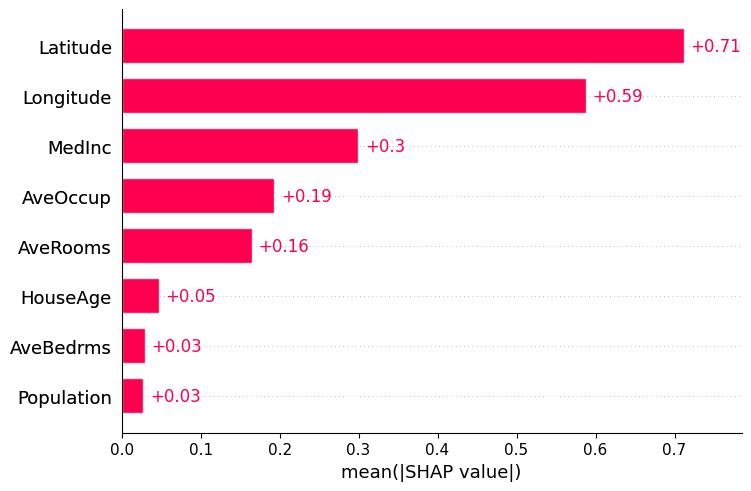

In [28]:
# bar plot to plot features importance

shap.plots.bar(shap_values)

In [29]:
shap_values.abs.mean(axis=0)

.values =
array([0.29955247, 0.04730885, 0.16476262, 0.02914534, 0.02726961,
       0.19317401, 0.71194115, 0.58765549])

.base_values =
np.float64(2.0126859115589673)

.data =
array([3.83033798e+00, 2.87642926e+01, 5.40405863e+00, 1.09663675e+00,
       1.42157171e+03, 2.96543102e+00, 3.55867103e+01, 1.19519360e+02])

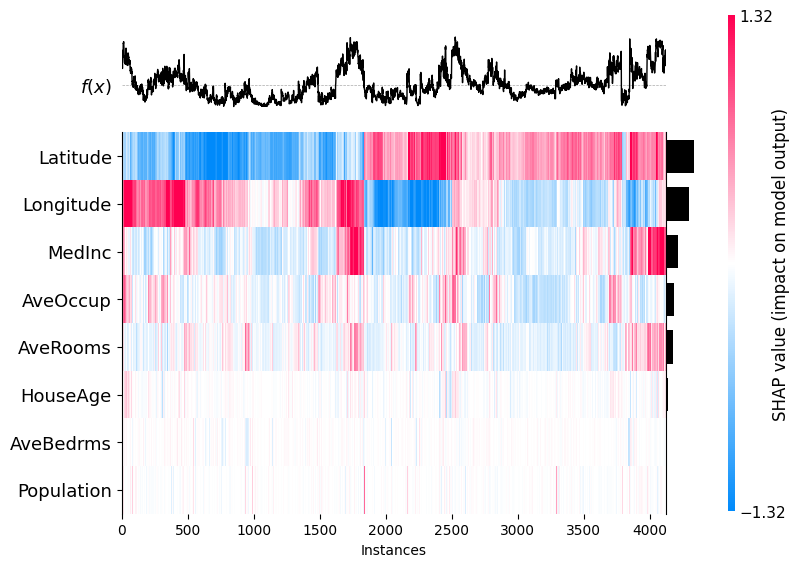

<Axes: xlabel='Instances'>

In [30]:
# heatmap plot

shap.plots.heatmap(shap_values)  

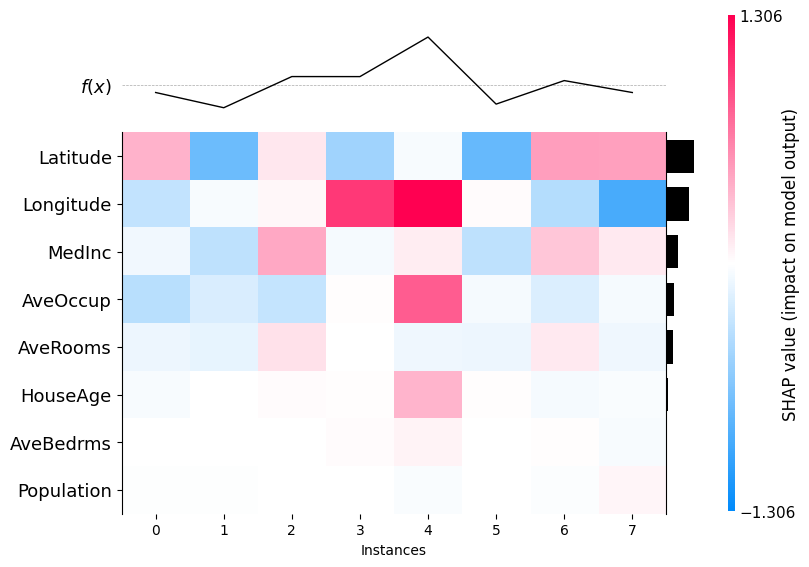

<Axes: xlabel='Instances'>

In [31]:
shap.plots.heatmap(shap_values,instance_order=shap_values.sum(0))

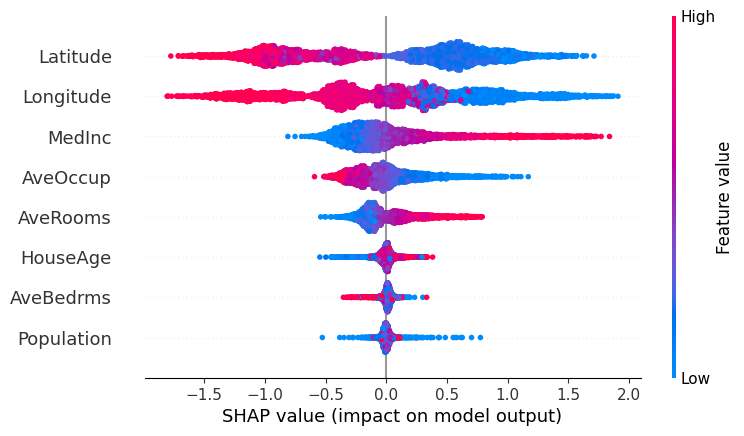

In [32]:
# summary plot
shap.plots.beeswarm(shap_values)

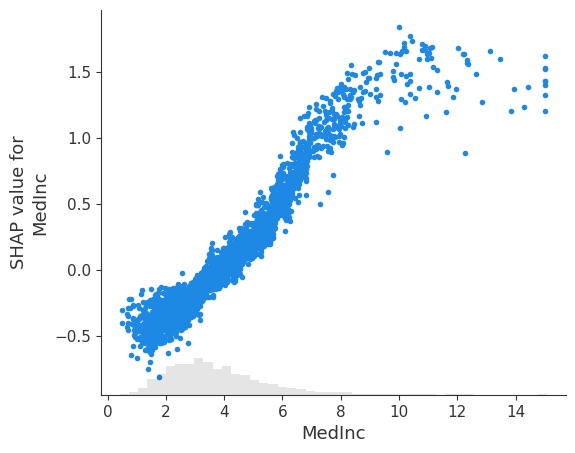

In [35]:
# Scatter plot ( Dependence plot )
shap.plots.scatter(shap_values[:,"MedInc"])

In [37]:
shap_values[:,"MedInc"]

.values =
array([-0.33486947, -0.33005286,  0.09556438, ...,  1.47735108,
       -0.22274767, -0.06617424], shape=(4128,))

.base_values =
array([2.01268591, 2.01268591, 2.01268591, ..., 2.01268591, 2.01268591,
       2.01268591], shape=(4128,))

.data =
array([1.6812, 2.5313, 3.4801, ..., 9.2298, 2.785 , 3.5521], shape=(4128,))

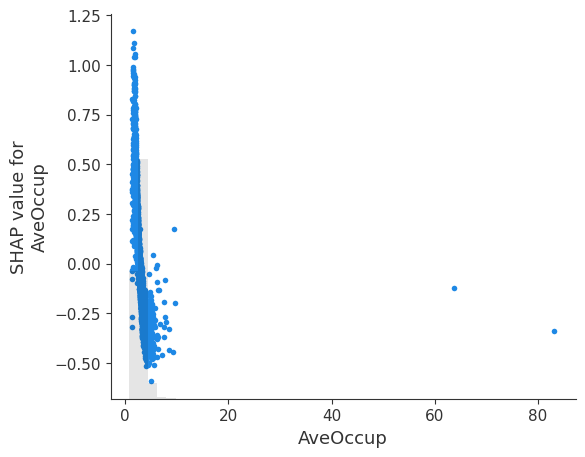

In [38]:
shap.plots.scatter(shap_values[:,"AveOccup"])

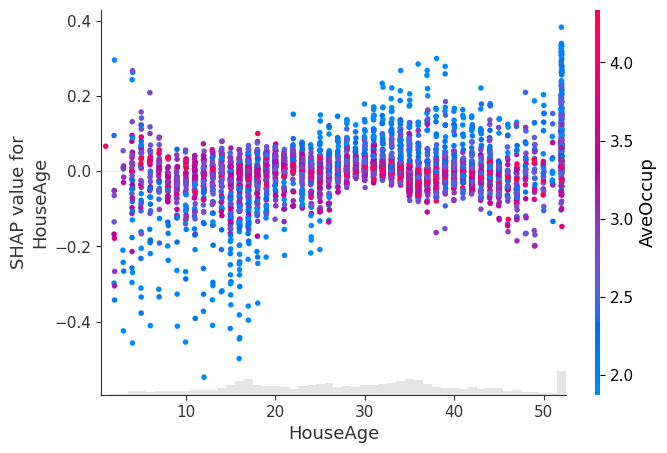

In [39]:
shap.plots.scatter(shap_values[:,"HouseAge"],color=shap_values)

## Local Plots

In [40]:
test_case = X_test.sample(1)

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
1396,3.7262,20.0,5.0,1.035191,856.0,2.510264,37.97,-122.07


In [41]:
explained_row = explainer(test_case)

explained_row

.values =
array([[-0.02425073,  0.03891598, -0.09611359,  0.00299026, -0.01140927,
         0.08407396, -1.0468987 ,  0.72868816]])

.base_values =
array([2.01268591])

.data =
array([[   3.7262    ,   20.        ,    5.        ,    1.03519062,
         856.        ,    2.51026393,   37.97      , -122.07      ]])

In [42]:
explained_row.shape

(1, 8)

In [43]:
explained_row[0,:].shape

(8,)

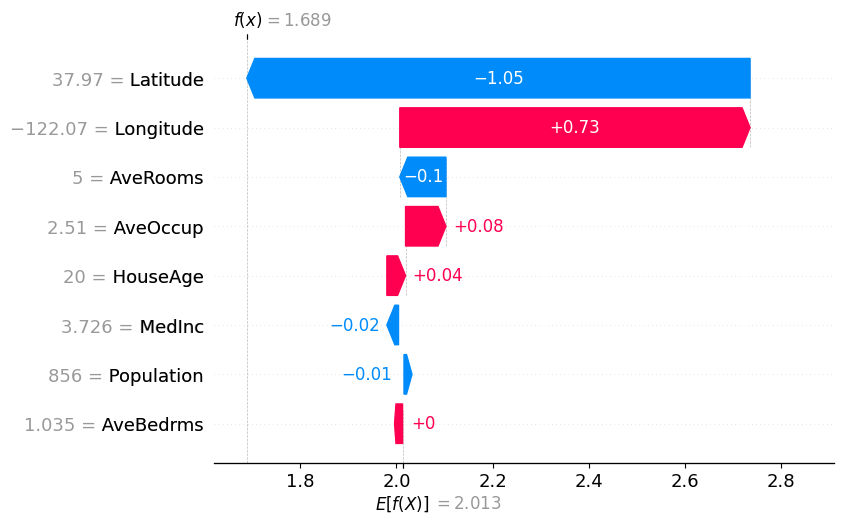

In [46]:
# waterfall plot 
shap.plots.waterfall(explained_row[0])

In [47]:
# force plot

shap.plots.initjs()

shap.plots.force(explained_row[0])

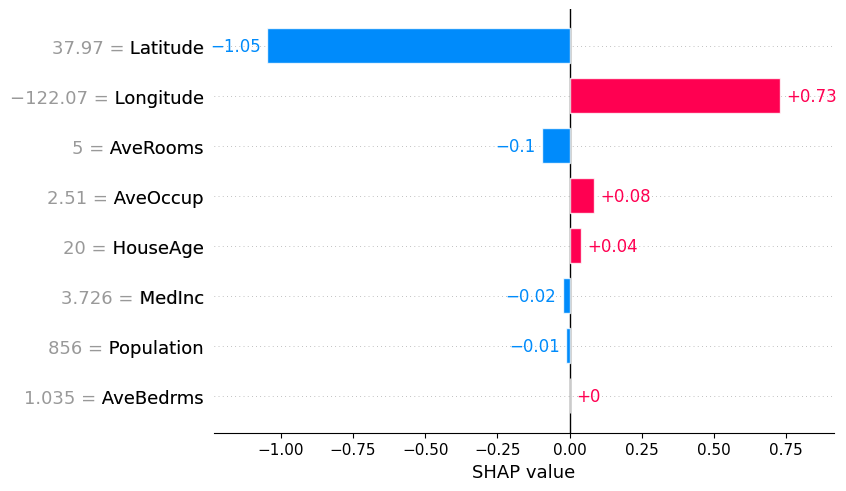

In [48]:
# bar plot for local explanation

shap.plots.bar(explained_row[0])